# Group Meeting Week 5
### [RN] 2/2/2021 2 PM

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

Extensions to SIR model:
https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model 
https://covid19-scenarios.org/ 
https://covid19scenarios.org/about 
https://www.medrxiv.org/content/10.1101/2020.05.05.20091363v2

Data sets:
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset?select=time_series_covid_19_confirmed_US.csv 
https://github.com/neherlab/covid19_scenarios/tree/master/data

Runge-Kutta method
https://rosettacode.org/wiki/Runge-Kutta_method#using_lambda


I need to check my SIR differential solver with Ari, and then decide on an extension and data set to fit. I did not folllow a direct method, but i think this solves the differential well. The fact that S+I+R=N at all times, which I have a function to check, is convincing. 

In [2]:
### Adapt function from Week 1 notebook for general use 

def SIR(I0, N, k, R0, dt, duration):
    g = k/R0
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R = np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        dS = -(k/N) * S[i-1]*I[i-1]*dt
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
    return S, I, R   # return S, I, and R arrays indexed by time. 

def CheckTotal(S, I, R, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i]
        if round(total, 0) != N:
            nonN = nonN+1
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.

Above is my SIR function from last week. I think I can use this function to fit raw data by varying I0, k, and R0. I will need to test different dt values to figure out how big of an affect that has on fit and error. I also will need to experiment with data slicing and choosing suitable durations of time 

## Find k from data sets
I want to extract a k from data sets. To do this I will slice the data into bins, and fit each bin linearly. Bins with slopes close to their neighbors are linear, and I will extract k from them. 

I like [this](https://github.com/rnnisi/covid19_scenarios) data best. I am going to copy the California time data set from this into my github and local files so that I can fit k. I forked this repo into my github and will be updating our notebook github as well. 

The data format is: 
0-3 comments 
4 headers: time    cases   deaths  hospitalized    icu     recovered

recovered is empty. 
There is one data point per day.

The data goes from March 4th, 2020 to January 21st 2021
### Extract and plot data sets

In [20]:
### write some useful functions 

def ReadFile(infile): # read infile, return contents list of each line
    read = open(infile, 'r')
    lines = read.readlines()
    read.close()
    return(lines)
# read raw data
raw = ReadFile("USA-California.tsv")

def TryFloat(val): # I want to convert nonempty data points to either floats or none so I can operate on these arrays. 
    try:
        val = float(val)
    except:
        val = None
    return val
        
# extract data 
date, cases, deaths, hospital, icu, recovered = [], [], [], [], [], []

for i in range(4, len(raw)): # split up raw data. it looks like there are bytes  b'\t' that seprate vals in addition to end characters. 
    thisset = raw[i]
    thisset = thisset.encode('utf-8') # encode data as bytes
    working = thisset.split(b'\t') # split data by byte
    for i in range(len(working)):
        working[i] = working[i].decode('utf8', 'strict') # put back as string for easier handling 
    date.append(working[0])
    cases.append(TryFloat(working[1]))
    deaths.append(TryFloat(working[2]))
    hospital.append(TryFloat(working[3]))
    icu.append(TryFloat(working[4]))
    recovered.append(working[5])




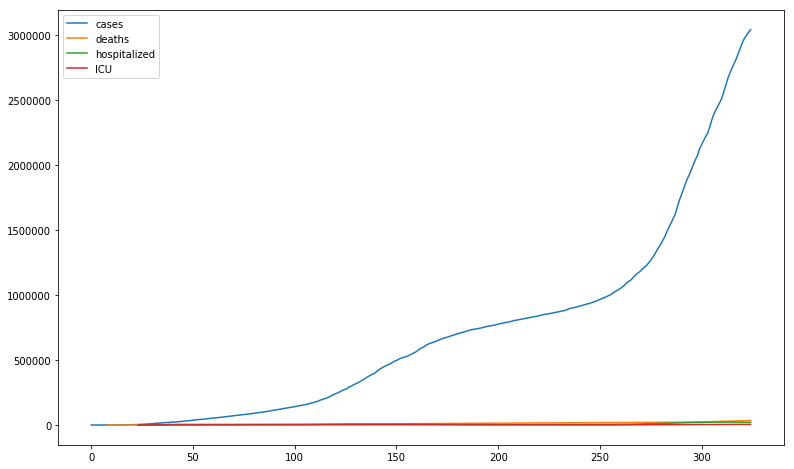

In [21]:
### make plots  

plt.rcParams['figure.figsize'] = [13, 8]

x = np.linspace(0, len(date), len(date))
# plot raw extracted data 
plt.plot(x, cases, label="cases")
plt.plot(x, deaths, label="deaths")
plt.plot(x, hospital, label="hospitalized")
plt.plot(x, icu, label="ICU")
plt.legend()


More links from ari 

https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/ https://iopscience.iop.org/article/10.1088/1742-6596/1040/1/012021/pdf

### Prepare data to extract k
### [RN] 2 pm

Clearly, I need to use a log scale. This is also how I will find k. 

I can reuse code i wrote last week. 

Text(0.5, 0, 'Days Passed Since March th 2020')

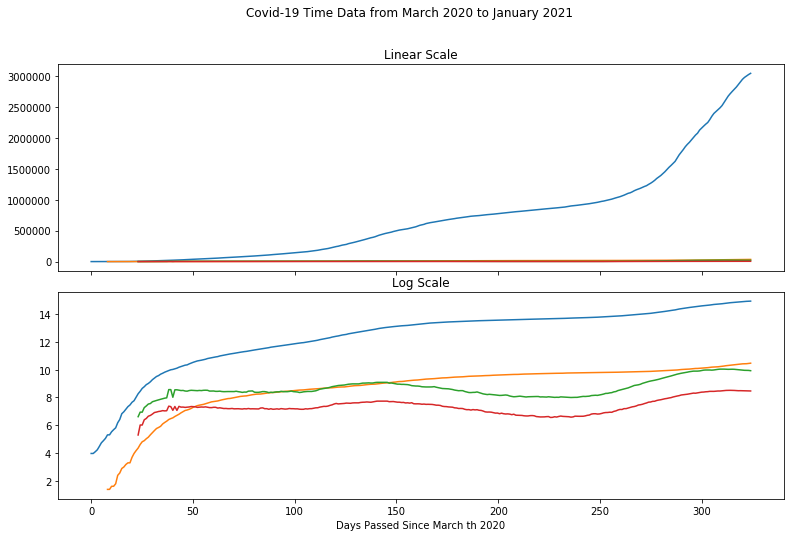

In [46]:
### log plots 

def LnData(dat):   # I coped this from 20210131 notebook
    lndat = np.zeros(len(dat))
    for i in range(len(dat)):
        try:
            lndat[i] = math.log(dat[i])
        except:
            lndat[i] = None
        
    return lndat
# plot data sets i downloaded from online 
fig2, axs2 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig2.suptitle("Covid-19 Time Data from March 2020 to January 2021")
axs2[0].plot(x, cases, label="cases")
axs2[0].plot(x, deaths, label="deaths")
axs2[0].plot(x, hospital, label="hospitalized")
axs2[0].plot(x, icu, label="ICU")
axs2[0].set_title("Linear Scale")
axs3[0].legend()


axs2[1].plot(x, LnData(cases), label="cases")
axs2[1].plot(x, LnData(deaths), label="deaths")
axs2[1].plot(x, LnData(hospital), label="hospitalized")
axs2[1].plot(x, LnData(icu), label="ICU")
axs2[1].set_title("Log Scale")
axs2[1].legend
plt.xlabel("Days Passed Since March th 2020")

### [RN] 2:51 
Took  break to go to work! 

The log scale actually lets me see the deaths, hospitalized, and ICU data. There is a noticably linear region within the first 50 days in the cases log scale plot. I will slice this data and extract coefficients from the logarithmic data. I should just do this for all four data sets and see what comes back. 

Deviation between hospital and ICU seems to be very constant. I am curious about that so i will look at that data more closely. Deaths and cases also seem to have relatively constant deviation in rate on the logarithmic plot over time. 


Text(0.5, 0, 'Days Passed Since March th 2020')

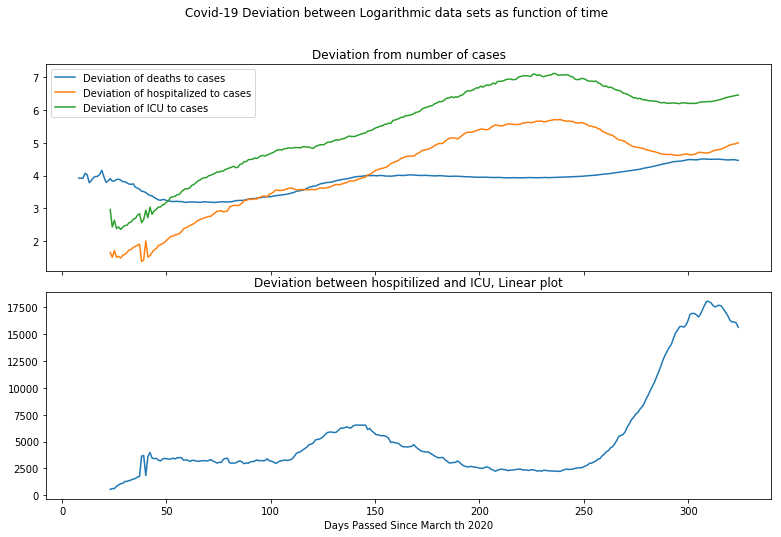

In [65]:
### Plot differences over time 

LnCases = LnData(cases) # convert data arrays to logarithmic 
LnDeaths = LnData(deaths)
LnHosp = LnData(hospital)
LnICU = LnData(icu)
def NormalDeviation(norm, set1): # function to get deviation between each time indexed value 
    delta1 = []
    max = max(norm)
    for i in range(len(norm)):
        try:
            delta = abs(norm[i] - set1[i])*(1/max)
        except:
            delta = None
        delta1.append(delta)
    return delta1

DevCasesDeaths = Deviation(LnCases, LnDeaths)
DevCasesHosp = Deviation(LnCases, LnHosp)
DevCasesICU = Deviation(LnCases, LnICU)
DevHospICU = Deviation(hospital, icu)

fig3, axs3 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig3.suptitle("Covid-19 Deviation between Logarithmic data sets as function of time")
axs3[0].plot(x, DevCasesDeaths, label = "Deviation of deaths to cases")
axs3[0].plot(x, DevCasesHosp, label = "Deviation of hospitalized to cases")
axs3[0].plot(x, DevCasesICU, label = "Deviation of ICU to cases")
axs3[0].set_title("Deviation from number of cases")
axs3[0].legend()

axs3[1].plot(x, DevHospICU)
axs3[1].set_title("Deviation between hospitilized and ICU, Linear plot")
plt.xlabel("Days Passed Since March th 2020")

### develop slicer and linear region 
### [RN] 3:30 

work is slow, ill keep going. I need to bin the data and find linear regions. I have already written code for another project that does this, so I will be using that below, slightly modified. 

Text(0.5, 1.0, 'Logarithmic Covid-19 Cases Data in Linearized Bins (Raw data set has 324 points)')

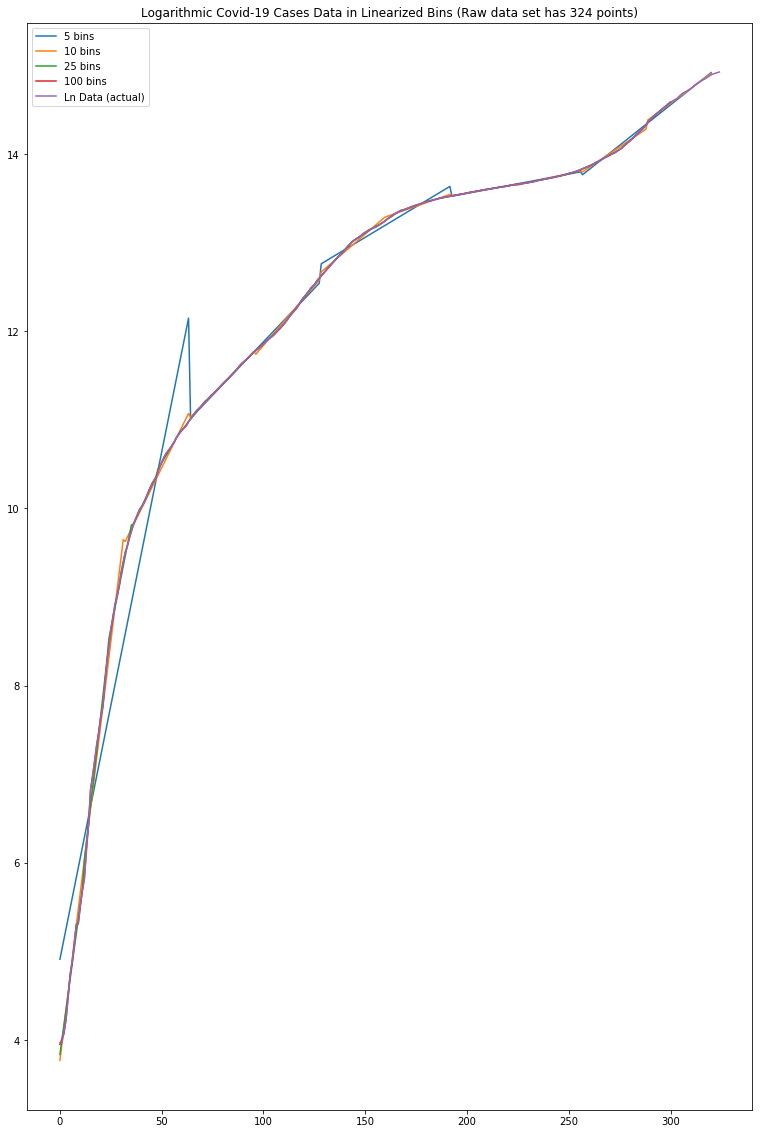

In [176]:
### data slicer

def Linearize(time, data, n):
        bin_size = int(len(data)/n) # bin data, analyze chunks in each bin 
        means, stds = [], [] # index mean and standard dev of each chunk
        line, fit = [], [] # index the slopes of each chunk and the linear fit
        chunks = [] # indexed array of each chunk
        for i in range(n):
                bottom = bin_size*i
                top = bottom + bin_size # get index of data chunk
                chunk = data[bottom:top] # chunk of data fills bin 
                chunks.append(chunk)
                if len(chunk) != bin_size: # skip if the bin is not full. keep weights equal
                        continue
                mean = stats.tmean(chunk)
                std = stats.tstd(chunk)
                c=np.polyfit(time[bottom:top], chunk, 1) # linear fit to chunk
                for j in time[bottom:top]:
                        line.append(c[0]*j+c[1])
                stds.append(std)
                fit.append(c) # fit will index the linear formula that best fits that chunk 
                means.append(mean)
        return line, fit, chunks, means, stds

fig4, axs4 = plt.subplots()       
line, fit, chunks, means, stds = Linearize(x, LnCases, 5)
axs4.plot(x[:len(line)], line, label = "5 bins")
line, fit, chunks, means, stds = Linearize(x, LnCases, 10)
axs4.plot(x[:len(line)], line, label = "10 bins")
line, fit, chunks, means, stds = Linearize(x, LnCases, 25)
axs4.plot(x[:len(line)], line, label = "25 bins")
line, fit, chunks, means, stds = Linearize(x, LnCases, 100)
axs4.plot(x[:len(line)], line, label = "100 bins")
axs4.plot(x, LnCases, label="Ln Data (actual)") 
plt.legend()
plt.title("Logarithmic Covid-19 Cases Data in Linearized Bins (Raw data set has " + str(len(cases)) + " points)")

It looks like even just 25 bins fits the 324 point data set just fine. Now I need to use the slopes to chose linear regions. I think the best way to do this is to examine each bins slope relative to the bins surrounding it. i can choose different percent differences to allow in slopes from neighbors. Then a collection of bins that has similar slopes can be used to extract one linear fit, and that is the k value for that area. I will use 27 bins, which gives 12 data point chunks, which feels appropriate. I can change it later if I need. 

It should be noted that I am losing data if last bin is unfull. I did this to keep each bin equally full and therefore equally weighted. 

Text(0.5, 1.0, 'Linear Regions binning, accepting only bins with similar slopes ')

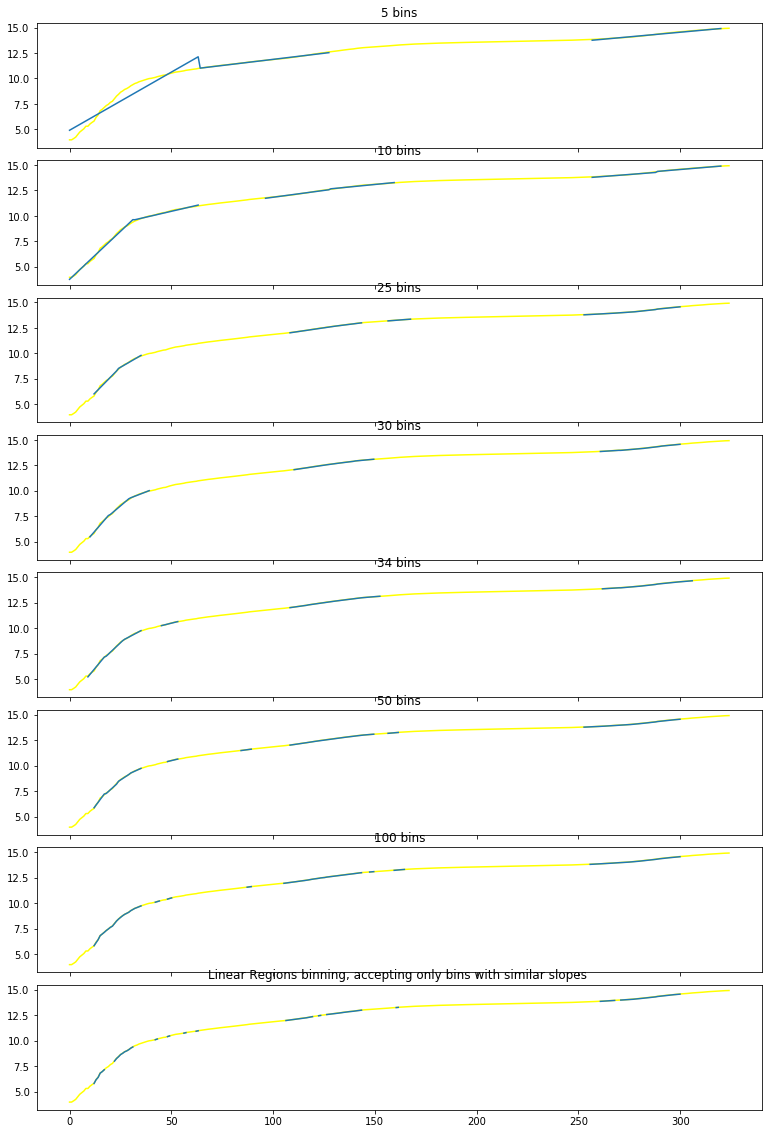

In [201]:
### Finding linear regions

def ExtractLinearRegions(chunks, fits, tolerance): # tolerance should be a scalar to apply to where we make the linear cut off
    linearized = [] # store data in linear chunks
    kvals = [] # store k vals. i will index them by linearized chunk
    Residuals = []
    useData = []
    useLine = []
    line = []
    index = []
    xcount = 0
    for i in range(len(chunks)):
        chunk = chunks[i]
        params = fits[i]
        resLocal = 0
        lineLocal = []
        for j in range(len(chunk)):
            generate = params[0]*xcount + params[1] # log residuals 
            resNow = generate - chunk[j]
            resLocal = resLocal + resNow
            lineLocal.append(generate)
            xcount = xcount+1
        Residuals.append(resLocal)
        line.append(lineLocal)
    rangeRes = max(Residuals) - min(Residuals) # set toleraence as the bins with residuals that show good fit to line
    for i in range(len(Residuals)):
        chunk = chunks[i]
        l = line[i]
        if Residuals[i] < min(Residuals) + rangeRes*tolerance:
            for k in range(len(chunk)):
                useLine.append(l[k])
                useData.append(chunk[k])
        else:
            for k in chunks[i]:
                useData.append(None)
                useLine.append(None)
    return useLine, useData
plt.rcParams['figure.figsize'] = [13, 20]
# I will iterate over bin sizes. Ill set tolerance to one standard dev and neighbors to 2. 
bins = [5, 10, 25, 30, 34, 50, 100, 150]

fig5, axs5 = plt.subplots(len(bins), sharex=True,sharey=True, gridspec_kw={'hspace':0.1})
plt.title("Testing different numbers of bins for finding linear data (nonlinear regions set to None)")
for i in range(len(bins)): 
    axs5[i].plot(x, LnCases, color = 'yellow')
    line, slopes, chunks, means, stds = Linearize(x, LnCases, bins[i])
    useLine, useData = ExtractLinearRegions(chunks, slopes, 0.7)
    axs5[i].plot(x[:len(useData)], useLine)
    axs5[i].set_title(str(bins[i]) +" bins")
plt.title("Linear Regions binning, accepting only bins with similar slopes ")



I actually think I will experiment with different bin sizes, and different acceptable deviations in mean from neighbor (tolerance). 